<a href="https://colab.research.google.com/github/BurgundyIsAPublicEnemy/ORLIAn/blob/main/data_preperation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preperation 
Usage: Set the variables below to the right place. Then hit run

Contributions: Nicolas Hegerle of JEDHA for coming up with a really elegant way of doing this

Pleae keep in mind this should run on your GPU

In [ ]:
IMAGEFILES = ''
TABULARTRAINING = ''
TABULARTEST = ''

# Stacked images
FULLSTACKTRAIN = ''

# Augmented data storages
# Please use your own here! Otherwise feel free to chip in on my Google Drive charges 
TRAIN_AUGMENTED_PATH = ''
TEST_AUGMENTED_PATH = ''

METADATA_PATH = ''

In [ ]:
# IMPORT ML MODEL RELATED THINGS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, cv2, shutil

from keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

In [ ]:
!pip install spams

### Set up normalizations (unused in the final model but go nuts if you like it)
Repo: https://github.com/wanghao14/Stain_Normalization

In [ ]:
"""
Uses the spams package:
http://spams-devel.gforge.inria.fr/index.html
Use with python via e.g https://anaconda.org/conda-forge/python-spams
"""

from __future__ import division

import numpy as np
import cv2 as cv
import spams
import matplotlib.pyplot as plt


##########################################

def read_image(path):
    """
    Read an image to RGB uint8
    :param path:
    :return:
    """
    im = cv.imread(path)
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    return im


def show_colors(C):
    """
    Shows rows of C as colors (RGB)
    :param C:
    :return:
    """
    n = C.shape[0]
    for i in range(n):
        if C[i].max() > 1.0:
            plt.plot([0, 1], [n - 1 - i, n - 1 - i], c=C[i] / 255, linewidth=20)
        else:
            plt.plot([0, 1], [n - 1 - i, n - 1 - i], c=C[i], linewidth=20)
        plt.axis('off')
        plt.axis([0, 1, -1, n])


def show(image, now=True, fig_size=(10, 10)):
    """
    Show an image (np.array).
    Caution! Rescales image to be in range [0,1].
    :param image:
    :param now:
    :param fig_size:
    :return:
    """
    image = image.astype(np.float32)
    m, M = image.min(), image.max()
    if fig_size != None:
        plt.rcParams['figure.figsize'] = (fig_size[0], fig_size[1])
    plt.imshow((image - m) / (M - m), cmap='gray')
    plt.axis('off')
    if now == True:
        plt.show()


def build_stack(tup):
    """
    Build a stack of images from a tuple of images
    :param tup:
    :return:
    """
    N = len(tup)
    if len(tup[0].shape) == 3:
        h, w, c = tup[0].shape
        stack = np.zeros((N, h, w, c))
    if len(tup[0].shape) == 2:
        h, w = tup[0].shape
        stack = np.zeros((N, h, w))
    for i in range(N):
        stack[i] = tup[i]
    return stack


def patch_grid(ims, width=5, sub_sample=None, rand=False, save_name=None):
    """
    Display a grid of patches
    :param ims:
    :param width:
    :param sub_sample:
    :param rand:
    :return:
    """
    N0 = np.shape(ims)[0]
    if sub_sample == None:
        N = N0
        stack = ims
    elif sub_sample != None and rand == False:
        N = sub_sample
        stack = ims[:N]
    elif sub_sample != None and rand == True:
        N = sub_sample
        idx = np.random.choice(range(N), sub_sample, replace=False)
        stack = ims[idx]
    height = np.ceil(float(N) / width).astype(np.uint16)
    plt.rcParams['figure.figsize'] = (18, (18 / width) * height)
    plt.figure()
    for i in range(N):
        plt.subplot(height, width, i + 1)
        im = stack[i]
        show(im, now=False, fig_size=None)
    if save_name != None:
        plt.savefig(save_name)
    plt.show()


######################################

def standardize_brightness(I):
    """
    :param I:
    :return:
    """
    p = np.percentile(I, 90)
    return np.clip(I * 255.0 / p, 0, 255).astype(np.uint8)


def remove_zeros(I):
    """
    Remove zeros, replace with 1's.
    :param I: uint8 array
    :return:
    """
    mask = (I == 0)
    I[mask] = 1
    return I


def RGB_to_OD(I):
    """
    Convert from RGB to optical density
    :param I:
    :return:
    """
    I = remove_zeros(I)
    return -1 * np.log(I / 255)


def OD_to_RGB(OD):
    """
    Convert from optical density to RGB
    :param OD:
    :return:
    """
    return (255 * np.exp(-1 * OD)).astype(np.uint8)


def normalize_rows(A):
    """
    Normalize rows of an array
    :param A:
    :return:
    """
    return A / np.linalg.norm(A, axis=1)[:, None]


def notwhite_mask(I, thresh=0.8):
    """
    Get a binary mask where true denotes 'not white'
    :param I:
    :param thresh:
    :return:
    """
    I_LAB = cv.cvtColor(I, cv.COLOR_RGB2LAB)
    L = I_LAB[:, :, 0] / 255.0
    return (L < thresh)


def sign(x):
    """
    Returns the sign of x
    :param x:
    :return:
    """
    if x > 0:
        return +1
    elif x < 0:
        return -1
    elif x == 0:
        return 0


def get_concentrations(I, stain_matrix, lamda=0.01):
    """
    Get concentrations, a npix x 2 matrix
    :param I:
    :param stain_matrix: a 2x3 stain matrix
    :return:
    """
    OD = RGB_to_OD(I).reshape((-1, 3))
    return spams.lasso(OD.T, D=stain_matrix.T, mode=2, lambda1=lamda, pos=True).toarray().T

In [ ]:
"""
Stain normalization based on the method of:
M. Macenko et al., ‘A method for normalizing histology slides for quantitative analysis’, in 2009 IEEE International Symposium on Biomedical Imaging: From Nano to Macro, 2009, pp. 1107–1110.
Uses the spams package:
http://spams-devel.gforge.inria.fr/index.html
Use with python via e.g https://anaconda.org/conda-forge/python-spams
"""

from __future__ import division

import numpy as np


def get_stain_matrix(I, beta=0.15, alpha=1):
    """
    Get stain matrix (2x3)
    :param I:
    :param beta:
    :param alpha:
    :return:
    """
    OD = RGB_to_OD(I).reshape((-1, 3))
    OD = (OD[(OD > beta).any(axis=1), :])
    _, V = np.linalg.eigh(np.cov(OD, rowvar=False))
    V = V[:, [2, 1]]
    if V[0, 0] < 0: V[:, 0] *= -1
    if V[0, 1] < 0: V[:, 1] *= -1
    That = np.dot(OD, V)
    phi = np.arctan2(That[:, 1], That[:, 0])
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100 - alpha)
    v1 = np.dot(V, np.array([np.cos(minPhi), np.sin(minPhi)]))
    v2 = np.dot(V, np.array([np.cos(maxPhi), np.sin(maxPhi)]))
    if v1[0] > v2[0]:
        HE = np.array([v1, v2])
    else:
        HE = np.array([v2, v1])
    return normalize_rows(HE)


###

class Macenko_Normalizer(object):
    """
    A stain normalization object
    """

    def __init__(self):
        self.stain_matrix_target = None
        self.target_concentrations = None

    def fit(self, target):
        target = standardize_brightness(target)
        self.stain_matrix_target = get_stain_matrix(target)
        self.target_concentrations = get_concentrations(target, self.stain_matrix_target)

    def target_stains(self):
        return OD_to_RGB(self.stain_matrix_target)

    def transform(self, I):
        I = standardize_brightness(I)
        stain_matrix_source = get_stain_matrix(I)
        source_concentrations = get_concentrations(I, stain_matrix_source)
        maxC_source = np.percentile(source_concentrations, 99, axis=0).reshape((1, 2))
        maxC_target = np.percentile(self.target_concentrations, 99, axis=0).reshape((1, 2))
        source_concentrations *= (maxC_target / maxC_source)
        return (255 * np.exp(-1 * np.dot(source_concentrations, self.stain_matrix_target).reshape(I.shape))).astype(
            np.uint8)

    def hematoxylin(self, I):
        I = standardize_brightness(I)
        h, w, c = I.shape
        stain_matrix_source = get_stain_matrix(I)
        source_concentrations = get_concentrations(I, stain_matrix_source)
        H = source_concentrations[:, 0].reshape(h, w)
        H = np.exp(-1 * H)
        return H

In [ ]:
"""
Normalize a patch stain to the target image using the method of:
E. Reinhard, M. Adhikhmin, B. Gooch, and P. Shirley, ‘Color transfer between images’, IEEE Computer Graphics and Applications, vol. 21, no. 5, pp. 34–41, Sep. 2001.
"""

from __future__ import division

import cv2 as cv
import numpy as np

### Some functions ###


def lab_split(I):
    """
    Convert from RGB uint8 to LAB and split into channels
    :param I: uint8
    :return:
    """
    I = cv.cvtColor(I, cv.COLOR_RGB2LAB)
    I = I.astype(np.float32)
    I1, I2, I3 = cv.split(I)
    I1 /= 2.55
    I2 -= 128.0
    I3 -= 128.0
    return I1, I2, I3


def merge_back(I1, I2, I3):
    """
    Take seperate LAB channels and merge back to give RGB uint8
    :param I1:
    :param I2:
    :param I3:
    :return:
    """
    I1 *= 2.55
    I2 += 128.0
    I3 += 128.0
    I = np.clip(cv.merge((I1, I2, I3)), 0, 255).astype(np.uint8)
    return cv.cvtColor(I, cv.COLOR_LAB2RGB)


def get_mean_std(I):
    """
    Get mean and standard deviation of each channel
    :param I: uint8
    :return:
    """
    I1, I2, I3 = lab_split(I)
    m1, sd1 = cv.meanStdDev(I1)
    m2, sd2 = cv.meanStdDev(I2)
    m3, sd3 = cv.meanStdDev(I3)
    means = m1, m2, m3
    stds = sd1, sd2, sd3
    return means, stds


### Main class ###

class Reinhard_Normalizer(object):
    """
    A stain normalization object
    """

    def __init__(self):
        self.target_means = None
        self.target_stds = None

    def fit(self, target):
        target = standardize_brightness(target)
        means, stds = get_mean_std(target)
        self.target_means = means
        self.target_stds = stds

    def transform(self, I):
        I = standardize_brightness(I)
        I1, I2, I3 = lab_split(I)
        means, stds = get_mean_std(I)
        norm1 = ((I1 - means[0]) * (self.target_stds[0] / stds[0])) + self.target_means[0]
        norm2 = ((I2 - means[1]) * (self.target_stds[1] / stds[1])) + self.target_means[1]
        norm3 = ((I3 - means[2]) * (self.target_stds[2] / stds[2])) + self.target_means[2]
        return merge_back(norm1, norm2, norm3)

In [ ]:
# Destroy folders we need
def emptyFolder(path):
  folder = path
  if os.path.exists(path):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

  if not os.path.exists(path):
    os.makedirs(path)

emptyFolder(METADATA_PATH)
emptyFolder(TRAIN_AUGMENTED_PATH)
emptyFolder(TEST_AUGMENTED_PATH)


In [ ]:
train_df = pd.read_csv(TABULARTRAINING)
train_df.head()

,id,OMS,sexe (0=F 1=M),DDN,Date biopsie,Age au diag,Deces Code,Code recidive,localisation,RNAscope,T,N,M,Tabac,Alcool,Data,OS
0,abf1b4,1,1,1954-06-17,2013-08-10,59,0,0,Oropharynx,2,4,2b,0,3,1,Image + clinical,84
1,a5969b,1,1,1937-02-09,2014-09-06,77,1,0,Oropharynx,1,4,2c,1,2,1,Image + clinical,24
2,aa21da,1,1,1968-04-09,2013-03-12,44,0,0,Oropharynx,2,3,3,0,3,1,Image + clinical,47
3,b075a7,1,1,1947-02-10,2014-11-08,67,1,0,Oropharynx,1,2,2c,0,2,1,Image + clinical,9
4,b2e232,1,1,1942-08-03,2014-04-23,71,0,1,Oropharynx,1,4,2b,1,2,0,Image + clinical,37


In [ ]:
train_df['N'].unique()

array(['2b', '2c', '3', '1', '2', '2a'], dtype=object)

In [ ]:
test_df = pd.read_csv(TABULARTEST)
test_df.head()

,id,OMS,sexe (0=F 1=M),DDN,Date biopsie,Age au diag,Deces Code,Code recidive,localisation,RNAscope,T,N,M,Tabac,Alcool,Data
0,ae0d22,3,1,1957-05-26,2011-12-05,54,0,1,Oropharynx,2,4,2c,0,0,1,Image + clinical
1,ac3e32,1,1,1953-04-16,2015-02-16,61,0,0,Oropharynx,2,4,2,0,1,1,Image + clinical
2,ad2573,0,1,1962-09-19,2014-10-07,52,0,0,Oropharynx,1,4,2b,0,3,1,Image + clinical
3,b37b6e,1,1,1938-04-15,2014-12-16,76,0,0,Oropharynx,1,4,0,1,2,1,Image + clinical
4,b631e6,1,1,1920-07-21,2013-11-04,93,1,1,Oropharynx,1,2,2b,0,0,1,Image + clinical


### Encode and unify the metadata

In [ ]:
train_df["localisation"] = train_df["localisation"].astype('category').cat.codes
train_df["N"] = train_df["N"].astype('category').cat.codes.head()

test_df["localisation"] = test_df["localisation"].astype('category').cat.codes
test_df["N"] = test_df["N"].astype('category').cat.codes.head()

# Dates into time since current epoch
train_df['DDN'] = round((pd.Timestamp.now() - pd.to_datetime(train_df['DDN'], format="%Y-%m-%d")).astype("int64") / (31556952 * 10**9))
train_df['Date biopsie'] = round((pd.Timestamp.now() - pd.to_datetime(train_df['Date biopsie'], format="%Y-%m-%d")).astype("int64") / (31556952 * 10**9))

test_df['DDN'] = round((pd.Timestamp.now() - pd.to_datetime(test_df['DDN'], format="%Y-%m-%d")).astype("int64") / (31556952 * 10**9))
test_df['Date biopsie'] = round((pd.Timestamp.now() - pd.to_datetime(test_df['Date biopsie'], format="%Y-%m-%d")).astype("int64") / (31556952 * 10**9))

In [ ]:
train_df.head()

,id,OMS,sexe (0=F 1=M),DDN,Date biopsie,Age au diag,Deces Code,Code recidive,localisation,RNAscope,T,N,M,Tabac,Alcool,Data,OS
0,abf1b4,1,1,68.0,8.0,59,0,0,0,2,4,3.0,0,3,1,Image + clinical,84
1,a5969b,1,1,85.0,7.0,77,1,0,0,1,4,4.0,1,2,1,Image + clinical,24
2,aa21da,1,1,54.0,9.0,44,0,0,0,2,3,5.0,0,3,1,Image + clinical,47
3,b075a7,1,1,75.0,7.0,67,1,0,0,1,2,4.0,0,2,1,Image + clinical,9
4,b2e232,1,1,79.0,8.0,71,0,1,0,1,4,3.0,1,2,0,Image + clinical,37


In [ ]:
train_df['N'].unique()

array([ 3.,  4.,  5., nan])

In [ ]:
test_df.head()

,id,OMS,sexe (0=F 1=M),DDN,Date biopsie,Age au diag,Deces Code,Code recidive,localisation,RNAscope,T,N,M,Tabac,Alcool,Data
0,ae0d22,3,1,65.0,10.0,54,0,1,0,2,4,4.0,0,0,1,Image + clinical
1,ac3e32,1,1,69.0,7.0,61,0,0,0,2,4,2.0,0,1,1,Image + clinical
2,ad2573,0,1,59.0,7.0,52,0,0,0,1,4,3.0,0,3,1,Image + clinical
3,b37b6e,1,1,84.0,7.0,76,0,0,0,1,4,0.0,1,2,1,Image + clinical
4,b631e6,1,1,101.0,8.0,93,1,1,0,1,2,3.0,0,0,1,Image + clinical


In [ ]:
path = "/content/drive/MyDrive/Epidemium Season 3/ORLIAn /image_data_v2/Cellule inflamatoire 2/a4fa68_[14458,48150]_composite_image.jpg"

target_img = cv2.imread(path) 

# Code Section for Images compiled from .JPGs in folders

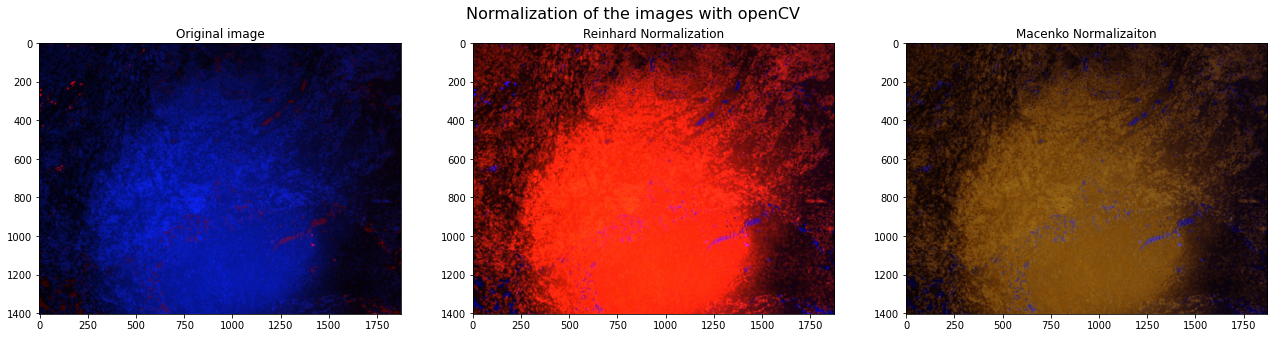

In [ ]:
# Demo function for augmentation

# Get colors isolated
reinhard_normalizer = Reinhard_Normalizer()
reinhard_normalizer.fit(target_img)
reinhard = reinhard_normalizer.transform(target_img)

macenko_normalizer = Macenko_Normalizer()
macenko_normalizer.fit(target_img)
macenko = macenko_normalizer.transform(target_img)

image = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 3, figsize =(22, 5))
fig.suptitle('Normalization of the images with different methods', fontsize = 16)
ax[0].set_title('Original image')
ax[1].set_title('Reinhard Normalization')
ax[2].set_title('Macenko Normalizaiton')

ax[0].imshow(image)
ax[1].imshow(reinhard)
ax[2].imshow(macenko)


In [ ]:
def MetaDataWriter(tabular, id, usage, fn, nfn, dir, layer, filetype):
  new_row = {'id': id , 'usage': usage, 'image_file': fn, 'image_rename': nfn, "current_directory": dir, "layer": layer, 'img_type': filetype}
  tabular = tabular.append(new_row, ignore_index=True)

  return tabular

## Load Images in the right place

In [ ]:
# Initalize variables so we can do this smoothly

unique_train_ids = train_df['id'].unique()
unique_test_ids = test_df['id'].unique()

train_img_data = pd.DataFrame(columns = ['id', 'usage', 'image_file', 'image_rename', 'current_directory', 'layer', 'img_type'])
test_img_data = pd.DataFrame(columns = ['id', 'usage', 'image_file', 'image_rename', 'current_directory', 'layer', 'img_type'])

#img_formats = ["raw", "reinhard", "macenko"]
img_formats = ["raw"]

### For training

In [ ]:
try:
  for dirname, _, filenames in os.walk(IMAGEFILES + ''):
      
      layers_folders = [i for i in os.listdir(dirname) if not i.endswith('.csv')] 
      
      for layer in layers_folders:
        if layer != "segmentation_tissue":
            img_files = [i for i in os.listdir(dirname + "/" + layer) if not i.endswith('.csv')] 

            for img_file in img_files:
                pid = img_file.split('_')[0]

                if pid in unique_train_ids:
                  old_image_path = IMAGEFILES + "/" + layer + "/" + img_file
                  tmp_img = cv2.imread(old_image_path) 

                  new_image_path = TRAIN_AUGMENTED_PATH + "/raw_" + layer + "_" + img_file                
                  
                  #stash the original copy somewhere easy
                  shutil.copy(old_image_path, new_image_path) 

                  for img_format in img_formats:
                      train_img_data = MetaDataWriter(train_img_data, pid, "train", img_file, img_format + "_" + layer + "_" + img_file, TRAIN_AUGMENTED_PATH, layer, img_format)

        elif layer == 'segmentation_tissue':
            img_files = [i for i in os.listdir(dirname + "/" + layer) if not i.endswith('.csv')] 
            for img_file in img_files:
                pid = img_file.split('_')[0]
                if pid in unique_train_ids:
                  old_image_path = IMAGEFILES + "/" + layer + "/" + img_file
                  tmp_img = cv2.imread(old_image_path) 

                  # Run Augmentations here
                  new_image_path = TRAIN_AUGMENTED_PATH + "/composite_" + layer + "_" + img_file 

                  #stash the original copy somewhere easy
                  shutil.copy(old_image_path, new_image_path)
                  
                  train_img_data = MetaDataWriter(train_img_data, pid, "train", img_file, "composite_" + layer + "_" + img_file, TRAIN_AUGMENTED_PATH, layer, "raw")
except:
  print("File found in a wrong place? Stop looking")

File found in a wrong place? Stop looking


### For validation set

In [ ]:
try:
  for dirname, _, filenames in os.walk(IMAGEFILES + ''):
    
    layers_folders = [i for i in os.listdir(dirname) if not i.endswith('.csv')] 
    
    for layer in layers_folders:
      if layer != "segmentation_tissue":
          img_files = [i for i in os.listdir(dirname + "/" + layer) if not i.endswith('.csv')] 

          for img_file in img_files:
              pid = img_file.split('_')[0]

              if pid in unique_test_ids:
                old_image_path = IMAGEFILES + "/" + layer + "/" + img_file

                tmp_img = cv2.imread(old_image_path) 

                new_image_path = TEST_AUGMENTED_PATH + "/raw_" + layer + "_" + img_file                
                
                shutil.copy(old_image_path, new_image_path)

                for img_format in img_formats:
                    test_img_data = MetaDataWriter(test_img_data, pid, "test", img_file, img_format + "_" + layer + "_" + img_file, TEST_AUGMENTED_PATH, layer, img_format)

      elif layer == 'segmentation_tissue':
          img_files = [i for i in os.listdir(dirname + "/" + layer) if not i.endswith('.csv')] 
          for img_file in img_files:
              pid = img_file.split('_')[0]
              if pid in unique_test_ids:
                old_image_path = IMAGEFILES + "/" + layer + "/" + img_file
                tmp_img = cv2.imread(old_image_path) 

                new_image_path = TEST_AUGMENTED_PATH + "/composite_" + layer + "_" + img_file 
                shutil.copy(old_image_path, new_image_path)
                
                test_img_data = MetaDataWriter(test_img_data, pid, "test", img_file, "composite_" + layer + "_" + img_file, TEST_AUGMENTED_PATH, layer, "raw")
except:
  print("File found in a wrong place? Stop looking")

File found in a wrong place? Stop looking


In [ ]:
train_img_data.head()

,id,usage,image_file,image_rename,current_directory,layer,img_type
0,aa21da,train,"aa21da_[12751,39928]_composite_image.jpg","raw_Cellule inflamatoire 1_aa21da_[12751,39928...",/content/drive/MyDrive/Kaggle/ORLIA/Train/,Cellule inflamatoire 1,raw
1,b02926,train,"b02926_[12109,48072]_composite_image.jpg","raw_Cellule inflamatoire 1_b02926_[12109,48072...",/content/drive/MyDrive/Kaggle/ORLIA/Train/,Cellule inflamatoire 1,raw
2,af8dca,train,"af8dca_[11334,62248]_composite_image.jpg","raw_Cellule inflamatoire 1_af8dca_[11334,62248...",/content/drive/MyDrive/Kaggle/ORLIA/Train/,Cellule inflamatoire 1,raw
3,a89f20,train,"a89f20_[12351,48430]_composite_image.jpg","raw_Cellule inflamatoire 1_a89f20_[12351,48430...",/content/drive/MyDrive/Kaggle/ORLIA/Train/,Cellule inflamatoire 1,raw
4,acd8f0,train,"acd8f0_[5988,42513]_composite_image.jpg","raw_Cellule inflamatoire 1_acd8f0_[5988,42513]...",/content/drive/MyDrive/Kaggle/ORLIA/Train/,Cellule inflamatoire 1,raw


In [ ]:
test_img_data.head()

,id,usage,image_file,image_rename,current_directory,layer,img_type
0,ad2573,test,"ad2573_[13475,49776]_composite_image.jpg","raw_Cellule inflamatoire 1_ad2573_[13475,49776...",/content/drive/MyDrive/Kaggle/ORLIA/Test/,Cellule inflamatoire 1,raw
1,ac3e32,test,"ac3e32_[12615,48956]_composite_image.jpg","raw_Cellule inflamatoire 1_ac3e32_[12615,48956...",/content/drive/MyDrive/Kaggle/ORLIA/Test/,Cellule inflamatoire 1,raw
2,b631e6,test,"b631e6_[15887,37878]_composite_image.jpg","raw_Cellule inflamatoire 1_b631e6_[15887,37878...",/content/drive/MyDrive/Kaggle/ORLIA/Test/,Cellule inflamatoire 1,raw
3,b37b6e,test,"b37b6e_[12327,51485]_composite_image.jpg","raw_Cellule inflamatoire 1_b37b6e_[12327,51485...",/content/drive/MyDrive/Kaggle/ORLIA/Test/,Cellule inflamatoire 1,raw
4,ac8a8b,test,"ac8a8b_[16004,54038]_composite_image.jpg","raw_Cellule inflamatoire 1_ac8a8b_[16004,54038...",/content/drive/MyDrive/Kaggle/ORLIA/Test/,Cellule inflamatoire 1,raw


## Mix the data together 

## OPTIONAL: Build a holdout from train
In the event test data is broken

In [ ]:
import random
train_minus_hold_df = train_df
if (True):
  print(len(train_minus_hold_df))
  holdout_index = []
  tmp_df = train_minus_hold_df
  for i in range(0, 7):
    cur = random.randint(0, len(tmp_df.index))
    while cur in holdout_index:
      cur = random.randint(0, len(tmp_df.index))
    holdout_index.append(cur)

  holdout_df = pd.DataFrame()

  holdout_df = tmp_df.loc[holdout_index]
  train_minus_hold_df = tmp_df.drop(tmp_df.index[holdout_index])
  holdout_df.head()
  print(len(train_minus_hold_df))
  print(len(holdout_df))

52
45
7


In [ ]:
# all training
train_img_data_all = train_img_data.merge(train_df, on = 'id')
train_img_data_all["id_encoding"] = train_img_data_all["id"].astype('category').cat.codes
train_img_data_all["image_rename_encoding"] = train_img_data_all["image_rename"].astype('category').cat.codes

train_img_data_all = train_img_data_all.sample(frac=1)
train_img_data_all.to_csv(METADATA_PATH + "train_img_data.csv", index=False, header=True)

if (True):
  #hold out - training
  train_img_data_minus_holdout = train_img_data.merge(train_minus_hold_df, on = 'id')
  train_img_data_minus_holdout["id_encoding"] = train_img_data_minus_holdout["id"].astype('category').cat.codes
  train_img_data_minus_holdout["image_rename_encoding"] = train_img_data_minus_holdout["image_rename"].astype('category').cat.codes
  
  train_img_data_minus_holdout = train_img_data_minus_holdout.sample(frac=1)

  train_img_data_minus_holdout.to_csv(METADATA_PATH + "train_minus_hold_img_data.csv", index=False, header=True)

  #hold out
  holdout_img_data_all = train_img_data.merge(holdout_df, on = 'id')
  holdout_img_data_all["id_encoding"] = holdout_img_data_all["id"].astype('category').cat.codes
  holdout_img_data_all["image_rename_encoding"] = holdout_img_data_all["image_rename"].astype('category').cat.codes
  
  holdout_img_data_all = holdout_img_data_all.sample(frac=1)

  holdout_img_data_all.to_csv(METADATA_PATH + "holdout_img_data.csv", index=False, header=True)

#all testing
test_img_data_all = test_img_data.merge(test_df, on = 'id')
test_img_data_all["id_encoding"] = test_img_data_all["id"].astype('category').cat.codes
test_img_data_all["image_rename_encoding"] = test_img_data_all["image_rename"].astype('category').cat.codes
test_img_data_all = test_img_data_all.sample(frac=1)

test_img_data_all.to_csv(METADATA_PATH + "test_img_data.csv", index=False, header=True)


# Sanity Check

In [ ]:
train_img_data_all.head(20)

,id,usage,image_file,image_rename,current_directory,layer,img_type,OMS,sexe (0=F 1=M),DDN,Date biopsie,Age au diag,Deces Code,Code recidive,localisation,RNAscope,T,N,M,Tabac,Alcool,Data,OS,id_encoding,image_rename_encoding
416,afdc1c,train,"afdc1c_[11130,46985]_composite_image.jpg","composite_segmentation_tissue_afdc1c_[11130,46...",/content/drive/MyDrive/Kaggle/ORLIA/Train/,segmentation_tissue,raw,0,0,63.0,9.0,54,0,0,0,2,2,NaN,0,0,1,Image + clinical,70,23,170
208,b3c9bb,train,"b3c9bb_[17242,51736]_composite_image.jpg","raw_Cellule inflamatoire 4_b3c9bb_[17242,51736...",/content/drive/MyDrive/Kaggle/ORLIA/Train/,Cellule inflamatoire 4,raw,1,1,77.0,8.0,69,0,0,0,1,2,NaN,0,0,1,Image + clinical,65,34,706
408,afdc1c,train,"afdc1c_[11130,46985]_composite_image.jpg","raw_Cellule inflamatoire 4_afdc1c_[11130,46985...",/content/drive/MyDrive/Kaggle/ORLIA/Train/,Cellule inflamatoire 4,raw,0,0,63.0,9.0,54,0,0,0,2,2,NaN,0,0,1,Image + clinical,70,23,669
307,b41668,train,"b41668_[18952,52941]_composite_image.jpg","raw_Cellule inflamatoire 1_b41668_[18952,52941...",/content/drive/MyDrive/Kaggle/ORLIA/Train/,Cellule inflamatoire 1,raw,1,1,80.0,9.0,71,1,1,0,2,4,NaN,1,3,1,Image + clinical,46,35,417
486,a4fa68,train,"a4fa68_[14949,49878]_image_with_tissue_seg.jpg","composite_segmentation_tissue_a4fa68_[14949,49...",/content/drive/MyDrive/Kaggle/ORLIA/Train/,segmentation_tissue,raw,0,1,66.0,9.0,57,0,0,0,2,4,NaN,0,3,1,Image + clinical,70,1,13
504,b1abe7,train,"b1abe7_[17050,33063]_composite_image.jpg","raw_Cellule inflamatoire 4_b1abe7_[17050,33063...",/content/drive/MyDrive/Kaggle/ORLIA/Train/,Cellule inflamatoire 4,raw,1,1,65.0,9.0,55,0,0,0,2,4,NaN,0,0,1,Image + clinical,72,28,688
419,afdc1c,train,"afdc1c_[11130,46985]_image_with_tissue_seg.jpg","composite_segmentation_tissue_afdc1c_[11130,46...",/content/drive/MyDrive/Kaggle/ORLIA/Train/,segmentation_tissue,raw,0,0,63.0,9.0,54,0,0,0,2,2,NaN,0,0,1,Image + clinical,70,23,171
984,adc0ca,train,"adc0ca_[13048,39960]_composite_image.jpg","composite_segmentation_tissue_adc0ca_[13048,39...",/content/drive/MyDrive/Kaggle/ORLIA/Train/,segmentation_tissue,raw,0,1,63.0,9.0,54,1,1,0,1,4,NaN,1,3,1,Image + clinical,13,18,136
583,b32f11,train,"b32f11_[13977,51658]_composite_image.jpg","composite_segmentation_tissue_b32f11_[13977,51...",/content/drive/MyDrive/Kaggle/ORLIA/Train/,segmentation_tissue,raw,1,1,78.0,9.0,69,1,1,0,2,4,NaN,1,3,1,Image + clinical,47,33,232
87,af8dca,train,"af8dca_[14059,55321]_composite_image.jpg",raw_Cellules tumorales et cellules inflammatoi...,/content/drive/MyDrive/Kaggle/ORLIA/Train/,Cellules tumorales et cellules inflammatoires 3,raw,1,1,79.0,8.0,71,0,1,0,1,4,NaN,1,2,0,Image + clinical,43,22,959


In [ ]:
len(train_img_data_all['id_encoding'].unique())

42

# Unit Tests

In [ ]:
# List out files
for dirname, _, filenames in os.walk(IMAGEFILES + ''):
  count = 0
  for filename in filenames:
      count = count + 1
  print(count , " files detected in " + dirname)

for dirname, _, filenames in os.walk(METADATA_PATH + ''):
  count = 0
  for filename in filenames:
      count = count + 1
  print(count , " files detected in " + dirname)


2  files detected in /content/drive/MyDrive/Epidemium Season 3/ORLIAn /image_data_v2
179  files detected in /content/drive/MyDrive/Epidemium Season 3/ORLIAn /image_data_v2/Cellule inflamatoire 1
179  files detected in /content/drive/MyDrive/Epidemium Season 3/ORLIAn /image_data_v2/Cellules tumorales et cellules inflammatoires 6
179  files detected in /content/drive/MyDrive/Epidemium Season 3/ORLIAn /image_data_v2/Cellule inflamatoire 5
179  files detected in /content/drive/MyDrive/Epidemium Season 3/ORLIAn /image_data_v2/Cellule inflamatoire 2
179  files detected in /content/drive/MyDrive/Epidemium Season 3/ORLIAn /image_data_v2/Cellule inflamatoire 4
179  files detected in /content/drive/MyDrive/Epidemium Season 3/ORLIAn /image_data_v2/Cellules tumorales et cellules inflammatoires 3
358  files detected in /content/drive/MyDrive/Epidemium Season 3/ORLIAn /image_data_v2/segmentation_tissue
0  files detected in /content/drive/MyDrive/Epidemium Season 3/ORLIAn /image_data_v2/segmentation_

In [ ]:
# Make sure all the IDs in the files are actually train / test
print(train_img_data_all["img_type"].unique())
print(test_img_data_all["img_type"].unique())

for ids in list(train_img_data_all['id'].unique()):
  if ids not in unique_train_ids:
    print("Train DF has a leak")

for ids in list(test_img_data_all['id'].unique()):
  if ids not in unique_test_ids:
    print("Train DF has a leak")

['raw']
['raw']


In [ ]:
test_img_data_all.duplicated().unique()

array([False])

In [ ]:
print(unique_train_ids)

['abf1b4' 'a5969b' 'aa21da' 'b075a7' 'b2e232' 'a4fa68' 'a4ad44' 'b67e5a'
 'a89f20' 'af4155' 'a801cb' 'a54803' 'b110d5' 'a67dfe' 'a93ad8' 'b1fa79'
 'aa6e3d' 'b293e2' 'aba442' 'b41668' 'afdc1c' 'b4b14e' 'a85076' 'b32f11'
 'a8ebaf' 'b24726' 'b4fddb' 'b5e396' 'b59738' 'b6cb24' 'b3c9bb' 'af8dca'
 'ae5b78' 'ad7219' 'acd8f0' 'ab55eb' 'aea82d' 'b1abe7' 'b02926' 'b0c41b'
 'adc0ca' 'a6cafe' 'a63042' 'aef4f0' 'b15d33' 'b54aba' 'a7660c' 'a9886a'
 'a71943' 'ab076b' 'a9d4f0' 'a5e38c']


In [ ]:
print(unique_test_ids)

['ae0d22' 'ac3e32' 'ad2573' 'b37b6e' 'b631e6' 'b462ff' 'a7b285' 'aabb0e'
 'ac8a8b']


In [ ]:
# Make sure all the photos are in the right places
for dirname, _, filenames in os.walk(METADATA_PATH + ''):
  for filename in filenames:
      if (not filename.endswith(".csv")):
        if (dirname.endswith("Train")):
          if (filename.split("_")[2] != "tissue"):
            if str(filename.split("_")[2]) not in unique_train_ids:
              print("Train leakage:", filename.split("_")[2])
        elif (dirname.endswith("Test")):
          if (filename.split("_")[2] != "tissue"):
            if str(filename.split("_")[2]) not in unique_test_ids:
              print("Test leakage:", filename.split("_")[2])

#Success = No output